# Demo notebook

This notebook shows how the main capabilities of the machine learning framework, from data collection to forecasting new COVID-19 cases in the Province of Trento, and it presents the analysis and discussion we carried out for our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['axes.labelsize'] = "large"

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression import linear_model
from patsy import dmatrices
from pmdarima.arima import OCSBTest

In [2]:
from ml.train_test_splitting import TsCvSplitter
from ml import Sarimax
from ml import model_selection
from ml.performance_measures import rmse
from ml import viz
from data.models import *
from data.dao import *

# Ingestion

Ingest curated data from MongoDB using the corresponding DAO and its modelling class to convert it to a pandas DataFrame.

In [3]:
df = CuratedData.to_df(CuratedDataMongoDao().get_by_date()).set_index("date")

In [4]:
# Warn if there are NA
cols_with_na = df.isna().sum()
for variable, na_count in cols_with_na.items():
    if na_count > 0:
        print(f"Warning: variable '{variable}' has {na_count} missing value{'s' if na_count > 1 else ''} --> forward fill")
        
# If last row has missing data, fill with last known value
df = df.fillna(method="ffill")

In [5]:
df.tail(14)

,cases,new_cases,deaths,new_deaths,active,recovered,quarantined,hospitalized,hospitalized_high_intensity,hospitalized_intensive_care,discharged,active_rsa_total,holiday,risk,stringency_index,new_first_doses_ag0,new_first_doses_ag1,new_first_doses_ag2,new_second_doses_ag0,new_second_doses_ag1,new_second_doses_ag2,new_first_doses,new_second_doses,first_doses_ag0,first_doses_ag1,first_doses_ag2,second_doses_ag0,second_doses_ag1,second_doses_ag2,first_doses,second_doses,vaccinated_population,fully_vaccinated_population
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-28,46902,25,1428,0,364,45110,356,6,0,0,2,0,False,white,75.46,1002,946,211,613,1819,132,2159,2564,41608,137468,140215,13927,92477,124015,319291,230419,0.588296,0.424548
2021-07-29,46947,45,1428,0,360,45159,352,6,0,0,2,0,False,white,75.46,1301,1176,161,810,1769,131,2638,2710,42909,138644,140376,14737,94246,124146,321929,233129,0.593156,0.429542
2021-07-30,46983,36,1428,0,364,45191,355,6,1,0,3,0,False,white,44.44,1135,1000,151,950,1949,536,2286,3435,44044,139644,140527,15687,96195,124682,324215,236564,0.597368,0.435871
2021-07-31,47017,34,1428,0,363,45226,353,8,2,0,2,0,False,white,50.00,417,609,41,117,239,26,1067,382,44461,140253,140568,15804,96434,124708,325282,236946,0.599334,0.436574
2021-08-01,47052,35,1428,0,383,45241,372,9,2,0,2,0,False,white,50.00,0,0,0,0,0,0,0,0,44461,140253,140568,15804,96434,124708,325282,236946,0.599334,0.436574
2021-08-02,47064,12,1428,0,387,45249,375,10,1,1,2,0,False,white,50.00,876,662,61,1029,2519,146,1599,3694,45337,140915,140629,16833,98953,124854,326881,240640,0.602280,0.443381
2021-08-03,47088,24,1428,0,352,45308,339,9,1,1,3,1,False,white,50.00,1290,1081,102,1080,2286,219,2473,3585,46627,141996,140731,17913,101239,125073,329354,244225,0.606837,0.449986
2021-08-04,47117,29,1428,0,379,45310,366,9,2,1,3,1,False,white,50.00,1321,1122,105,1317,2036,150,2548,3503,47948,143118,140836,19230,103275,125223,331902,247728,0.611532,0.456440
2021-08-05,47150,33,1428,0,376,45346,361,11,1,1,3,1,False,white,50.00,1450,1283,167,1467,1780,91,2900,3338,49398,144401,141003,20697,105055,125314,334802,251066,0.616875,0.462591


In [6]:
# Check data
print("Date range:", df.index[0].date(), "-", df.index[-1].date())
print("Shape (rows, columns):", df.shape)
print("Missing values (column name, number of empty rows):", 
      [(i, v) for i, v in df.isna().sum().to_dict().items() if v > 0])

Date range: 2020-03-07 - 2021-08-10
Shape (rows, columns): (526, 33)
Missing values (column name, number of empty rows): [('risk', 19)]


The starting dataset is composed of 33 variables that describe, in total, the progress of the epidemic in Trentino from 3 March 2020 to the present day. To improve the understanding of the data the variables are grouped into the following categories:

* Health situation in the province of Trento. The 12 variables monitor the provincial situation and count:
    
    * the cumulative total of the number of positive ``cases``, ``deaths`` and recoveries (``recovered``) since the day of the first record;
    * the daily variation of number of cases (`new_cases`) and deaths (`new_deaths`) with respect to the previous day;
    * the daily count of the number of people who are positive (`active`), in home isolation (`quarantined`) or `hospitalized`, of which in high-intensity units (`hospitalized_high_intensity`) and intensive care units (`hospitalized_intensive_care`), and the number of positive cases in nursing homes (`active_rsa_total`).
        
* National holidays. The boolean variable ``holiday`` indicates whether the reference day is a holiday. It will be used to understand if the number of new cases increases after holiday periods.
    
* Epidemiological scenario. The categorical variable ``risk`` refers to the provincial epidemiological scenario identified by 4 colours - white, green, yellow, red - in increasing order of intensity of the restrictions applied in Trentino through official ordinances. Periods with a "red" colour, for example, may indicate either periods in which the risk of contagion is particularly high or periods coinciding with festivities, in which it is necessary to avoid gatherings of people and a consequent worsening of the health situation.
    
* Stringency Index (`stringency_index`). It records the strictness of 'lockdown style' policies that primarily restrict people's behaviour. It is calculated on a national basis using all ordinal containment and closure policy indicators, plus an indicator recording public information campaigns.
    
* Progress of the vaccination campaign. The last 18 variables refer to the number of vaccines inoculated in Trentino. 
The vaccines administered to date require two doses to guarantee satisfactory effectiveness against infection. The total number and variations ("new_") compared to the previous day of the first and second doses inoculated are therefore recorded, as well as the differentiation by age:
    * ag0: people aged <30
    * ag1: people aged 30-60
    * ag2: people aged >60
 
 Finally, data are recorded on the percentage of the population vaccinated with at least one dose (`vaccinated_population`) and with both (`fully_vaccinated_population`).

# Preprocessing

We keep only a fraction of the available quantities for the rest of the analysis.

In [7]:
# Set daily frequency in datetime index (ensures there is one row per day)
df = df.asfreq("D")

# Set output and regressors
regressors = ['stringency_index', 'first_doses_ag0', 'first_doses_ag1',
       'first_doses_ag2', 'second_doses_ag0', 'second_doses_ag1',
       'second_doses_ag2', 'first_doses', 'second_doses']

outputs = ["new_cases"]

# Separate outputs and regressors
x = df[regressors]
y = df[outputs]

# Variables inspection

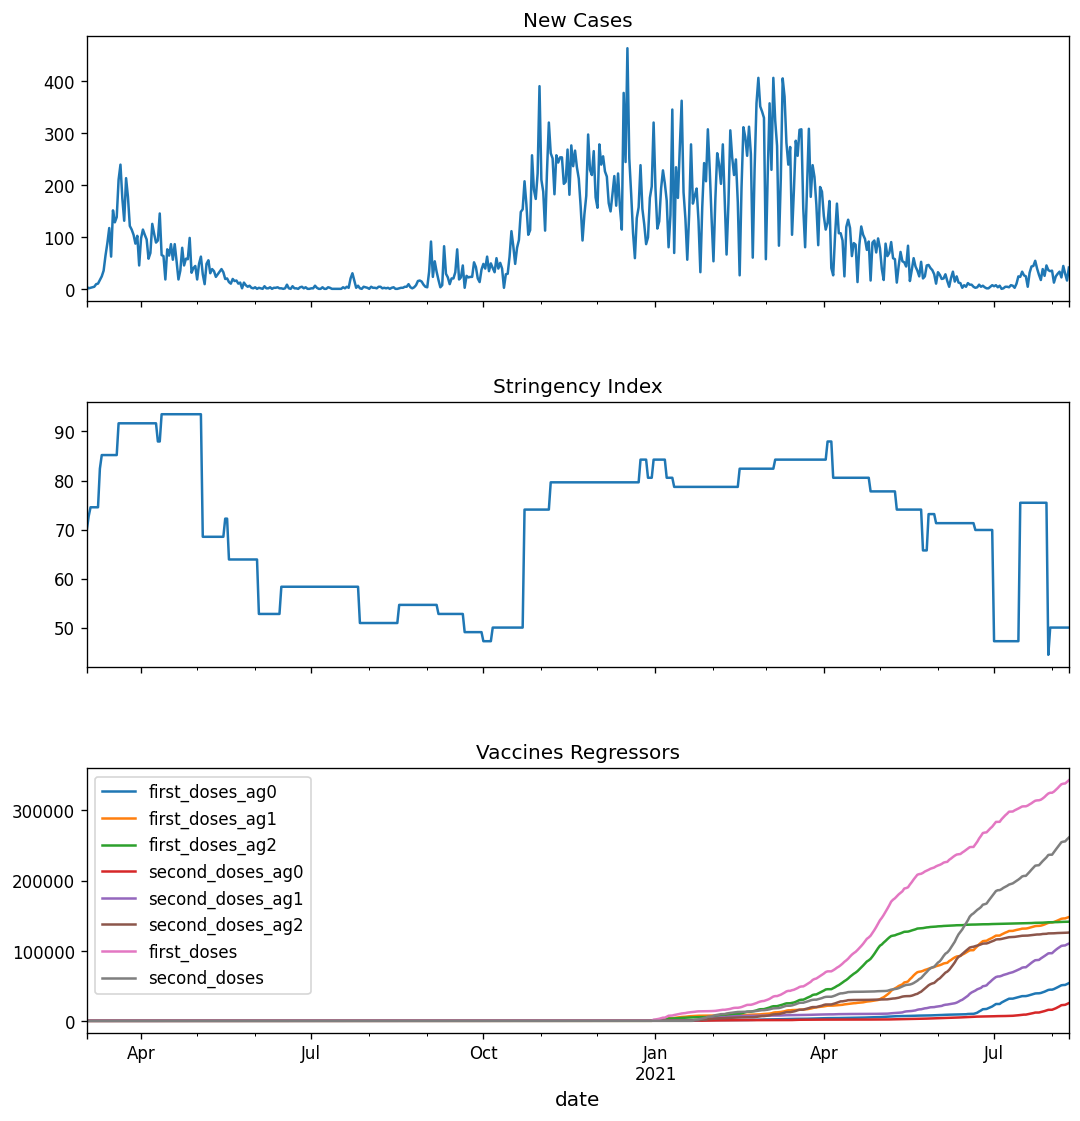

In [8]:
# Inspect output and regressors
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':120})

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
fig.tight_layout(pad=5.0)

y.plot(ax=axes[0], legend = False); axes[0].set_title('New Cases')
x[regressors[0]].plot(ax=axes[1]); axes[1].set_title('Stringency Index')
x[regressors[1:]].plot(ax=axes[2]); axes[2].set_title('Vaccines Regressors')
axes[2].legend(loc='upper left')
plt.show()

In the last plot it is worth noting that the data are 0 for most series since the vaccination campaign started in Italy on December 27th, 2020. In order to improve the forecasts, it will therefore be necessary to cut the data from the start date of the campaign.

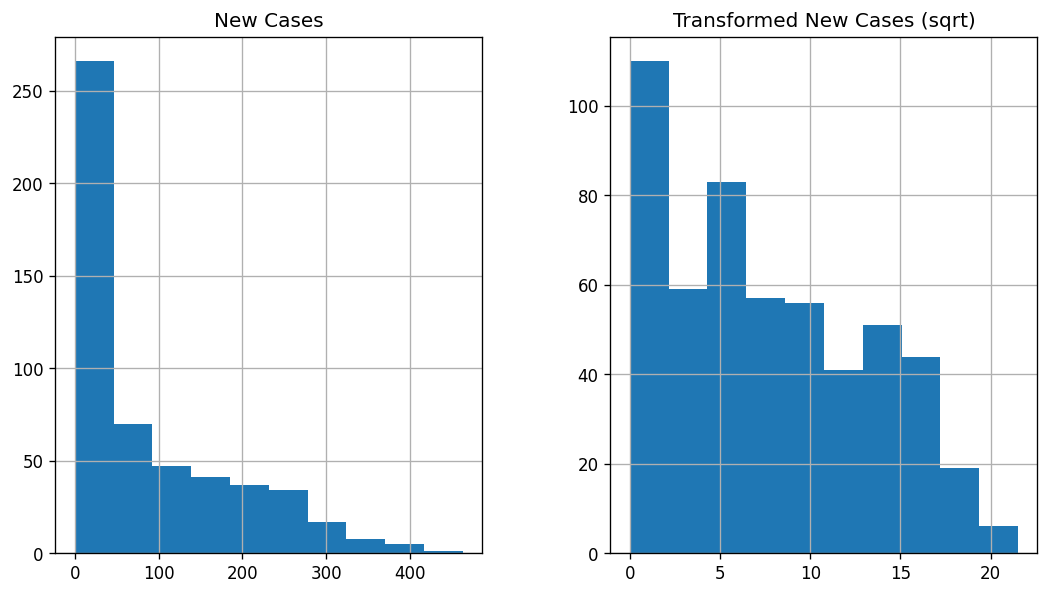

In [9]:
# inspect y's distribution and transform it in order to approximate it to a normal distribution
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout(pad=5.0)

y.hist(ax=axes[0]); axes[0].set_title('New Cases')

y_tran = np.sqrt(df[outputs])
y_tran.hist(ax=axes[1]); axes[1].set_title('Transformed New Cases (sqrt)');

# Model 1: SARIMA (no exogenous variables)

The first model that we study is a simple SARIMA model without exogenous regressors. This model uses only the variable to be predicted and does not take into account any other variables among those available.

In [10]:
# Create dataset ready to be analysed
data = y_tran.join(x)
data.tail()

,new_cases,stringency_index,first_doses_ag0,first_doses_ag1,first_doses_ag2,second_doses_ag0,second_doses_ag1,second_doses_ag2,first_doses,second_doses
date,,,,,,,,,,
2021-08-06,4.690416,50.0,50733,145555,141144,22341,106899,125522,337432,254762
2021-08-07,6.633250,50.0,51077,145980,141188,22652,107337,125540,338245,255529
2021-08-08,5.385165,50.0,51195,146092,141197,22832,107537,125545,338484,255914
2021-08-09,4.000000,50.0,52442,147015,141287,24119,109005,125710,340744,258834
2021-08-10,6.403124,50.0,53747,148006,141392,25287,110153,125934,343145,261374


## Preliminary analysis: set of hyperparameters

ARIMA is characterized by 3 terms:

* the order of autoregressive (AR) term - *p*. It is the number of immediately preceding values in the series necessary to predict the value at the present time. It can be chosen by visually inspecting the plot of partial autocorrelation (PACF), i.e. the plot describing the correlation between the series and its lag after excluding the contribution of intermediate lags. 

* the order of differencing (I) - *d*. It is the number of differencing necessary to make the time series stationary. It can be defined qualitatively by inspecting the plot of autocorrelation (ACF): the time series must be differentiated as long as correlations are positive for many number of lags. Moreover, the Augmented Dickey Fuller (adfuller) test can be performed to check time series' stationarity.

* the order of the moving average (MA) term - *q*. It incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations. It corresponds to the number of errors of the lagged forecast required to remove any autocorrelation in the stationarized series. As well as the order of differencing, it can be defined qualitatively by inspecting the ACF plot: it is chosen as the number of lags well above the significance line.

d:\local_project_repos\bdt_project_2021\covid19learning\venv\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


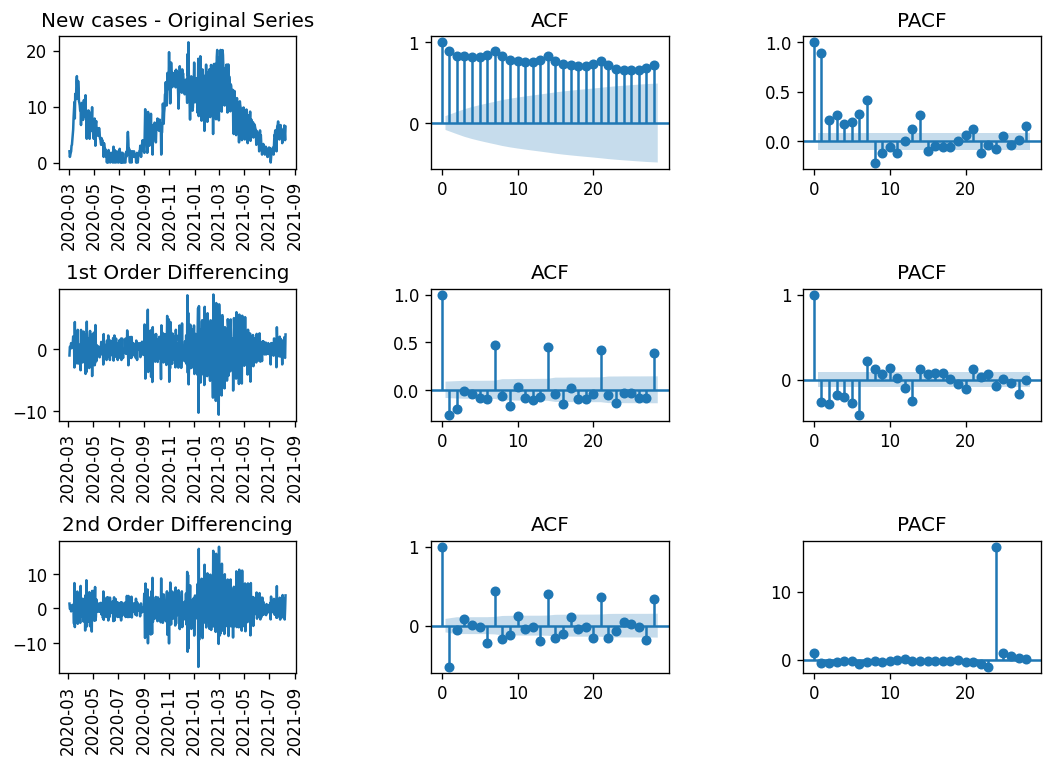

In [11]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3, sharex=False)
fig.tight_layout(pad=5.0)
axes[0, 0].tick_params(axis='x', rotation=90)
axes[0, 0].plot(data[outputs]); axes[0, 0].set_title('New cases - Original Series')
plot_acf(data[outputs], ax=axes[0, 1]); axes[0, 1].set_title('ACF')
plot_pacf(data[outputs], ax=axes[0, 2]); axes[0, 2].set_title('PACF')

# 1st Differencing
axes[1, 0].tick_params(axis='x', rotation=90)
axes[1, 0].plot(data[outputs].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data[outputs].diff().dropna(), ax=axes[1, 1]); axes[1, 1].set_title('ACF')
plot_pacf(data[outputs].diff().dropna(), ax=axes[1, 2]); axes[1, 2].set_title('PACF')

# 2nd Differencing
axes[2, 0].tick_params(axis='x', rotation=90)
axes[2, 0].plot(data[outputs].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data[outputs].diff().diff().dropna(), ax=axes[2, 1]); axes[2, 1].set_title('ACF')
plot_pacf(data[outputs].diff().diff().dropna(), ax=axes[2, 2]); axes[2, 2].set_title('PACF')

plt.show()

**Order of differencing (d):**


The plots above are used to qualitatively define the ARIMA terms. 
The ACF plot of the time series shows that the series is not stationary, so it will require differentiation.
By comparing the ACF plots with order of differentiation equal to 1 and 2 we see that with the latter we get a strong negative autocorrelation at lag1, so the series might be over differentiated. To check time series stationarity the adfuller test is performed.

The time series is stationary with order of differentiation of 1


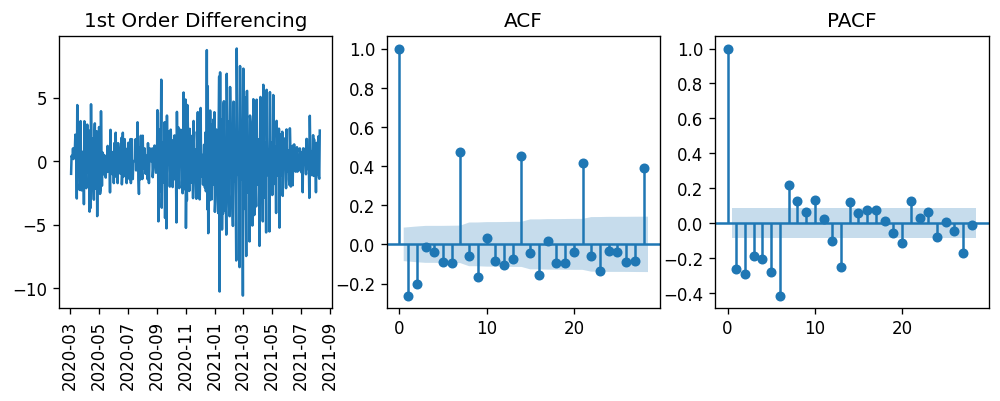

In [12]:
# Determine d parameter
def test_stationarity_adfuller(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    critical_value, test_statistic, alpha, pvalue = dftest[4]['5%'], dftest[0], 1e-3, dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        return True
    else:
        return False
    
# Determine d parameter
ts_diff = y_tran
d = 0
while test_stationarity_adfuller(ts_diff) is False:
    ts_diff = ts_diff.diff().dropna()
    d = d + 1
print(f'The time series is stationary with order of differentiation of {d}')

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 3, sharex=False)
axes[0].tick_params(axis='x', rotation=90)
axes[0].plot(data[outputs].diff()); axes[0].set_title('1st Order Differencing')
plot_acf(data[outputs].diff().dropna(), ax=axes[1]); axes[1].set_title('ACF')
plot_pacf(data[outputs].diff().dropna(), ax=axes[2]); axes[2].set_title('PACF');

**AR term (p):**
    
Inspecting the PACF plot shows that lags 1 to 6 are significantly different from 0, indicating lagged terms of y that are useful predictors of current y. 

**MA term (q):**

Inspecting the ACF plot shows that lags 1 and 2 are significantly different from 0.

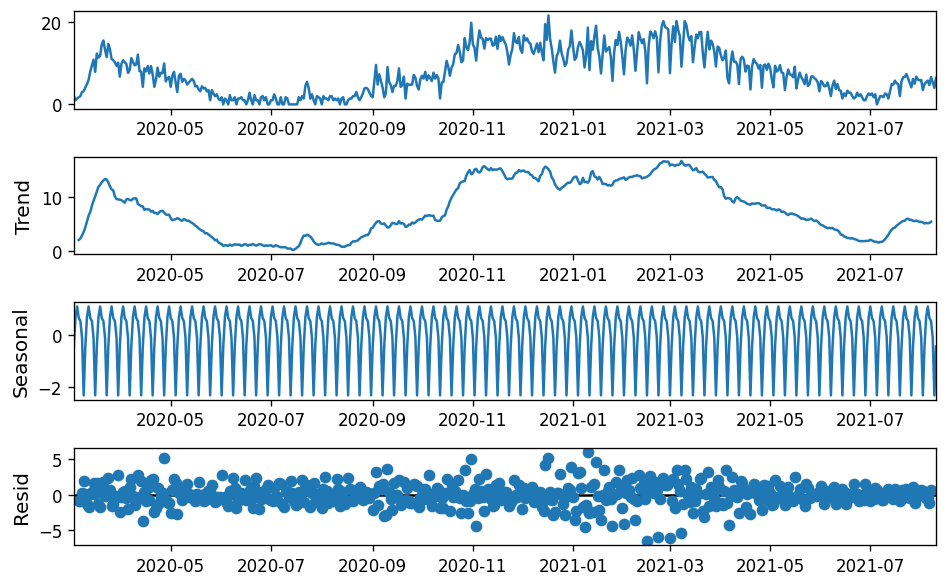

In [13]:
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':120})

components = seasonal_decompose(data[outputs])
components.plot();

Both in ACF and in time series decomposition it is worth of notice the seasonal component of 7 days, so a SARIMA model is applied. It includes the 3 ARIMA terms plus 3 more seasonal terms listed above:

* Seasonal autoregressive (SAR) term - *P*. 

* Order of seasonal differencing term - *D*. It can be determined by performing Osborn, Chui, Smith, and Birchenhall (OCSB) test.

* Seasonal moving average (SMA) term - *Q*.

* Period for seasonal differencing (m). It refers to the number of periods in each season, in this case is set to 7.

**Order of seasonal differencing (D):**

In [14]:
# Determine D parameter
D = OCSBTest(m=7).estimate_seasonal_differencing_term(y_tran)
print(f'The estimated order of seasonal differencing is {D}{": the series does not need seasonal differencing" if D == 0 else ""}.')

The estimated order of seasonal differencing is 0: the series does not need seasonal differencing.


Based on the above considerations, we set the range of hyperparameters on which to perform exhaustive search in the process as in the following configuration:
```
{
  "outputs": ["new_cases"],
  "regressors": [],
  "date_from": "2020",
  "p_values": [0,1,2,3,4,5],
  "d_values": [1],
  "q_values": [0,1,2,3,4,5],
  "P_values": [0, 1, 2],
  "D_values": [0],
  "Q_values": [0, 1, 2],
  "m_values": [7],
  "t_values": ["n"],
  "performance_measure": "rmse",
  "cv_n_splits": 30,
  "cv_max_test_size": 7,
  "parallel": true,
  "debug": false
}  
```

Starting from this, a list of possible configurations is created, for each one the SARIMA model is selected and cross validation is applied to obtain the root mean squared error (rmse) of the model. Each model with its respective performances is uploaded to MongoDB in order of increasing rmse so that the best configuration is always the first one.

The cross validation performed with this configuration is an 30-fold cross validation described as in the documentation, which also describes the other keys in the dictionary.

## Analysis of the best performing model (no exogenous variables)

In [15]:
# Get best configuration from MongoDB
htrdao = HyperparameterTuningResultMongoDao()
htr_endog = htrdao.get_most_recent_record("new_cases", [])
# Extract best configuration from htr result
best_config_endog = htr_endog[0].results[0]["cfg"]

In [16]:
# Create splits for cross validation
splitter = TsCvSplitter(n_splits=30, max_test_size=7)
splits = splitter.split(y)
(splitter.min_train_size, splitter.max_train_size)

(46, 510)

In [17]:
# Instantiate the model with the best selected configuration, and apply the transformation
model = Sarimax(y, config=best_config_endog, transformation='sqrt', convergence_warnings=False)

In [18]:
# Fit the model and cross validate for evaluation
model.fit().cross_validate(splits)
print(model)

SARIMAX {'arima_order': [4, 1, 5], 'seasonal_order': [1, 0, 1, 7], 'trend': 'n'}
   transformation: sqrt
   trained (AIC=2045.7233109328236)
   cross_validated {'RMSE': 34.69652132312452, 'RMSE_se': 6.6010928171439005}


In [19]:
model.get_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  526
Model:             SARIMAX(4, 1, 5)x(1, 0, [1], 7)   Log Likelihood               -1010.862
Date:                             Thu, 12 Aug 2021   AIC                           2045.723
Time:                                     23:06:10   BIC                           2096.583
Sample:                                 03-03-2020   HQIC                          2065.660
                                      - 08-10-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7722      0.727      1.063      0.288      -0.652       2.196
ar.L2          0.5143      1.019      0.505      0.614      -1.483       2.511
ar.L3         -0.1082      0.296     -0.366      0.714      -0.688       0.471
ar.L4         -0.3002      0.270     -1.113      0.266      -0.829       0.229
ma.L1         -1.3777      0.730     -1.887      0.059      -2.809       0.053
ma.L2         -0.2319      1.454     -0.159      0.873      -3.082       2.618
ma.L3          0.6438      0.666      0.967      0.334      -0.662       1.949
ma.L4          0.2417      0.497      0.486      0.627      -0.732       1.216
ma.L5         -0.2364      0.259     -0.913      0.361      -0.744       0.271
ar.S.L7        0.9588      0.021     44.797      0.000       0.917       1.001
ma.S.L7       -0.7339      0.048    -15.413      0.000      -0.827      -0.641
sigma2         2.9604      0.138     21.481      0.000       2.690       3.231
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               100.92
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.22
Prob(H) (two-sided):                  0.87   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

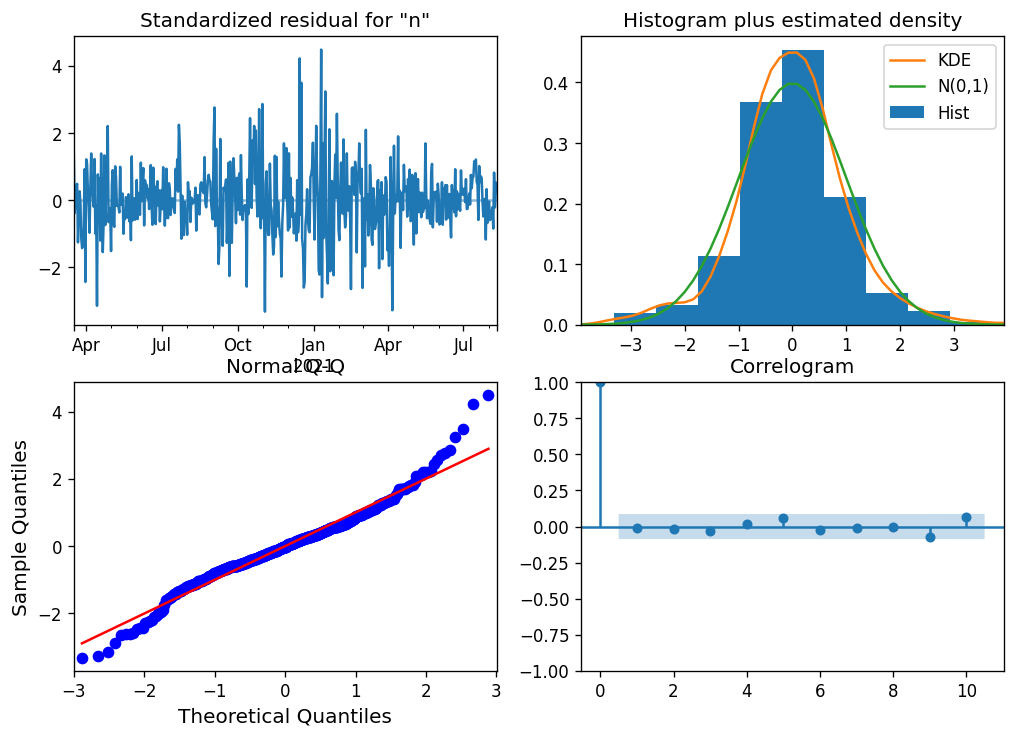

In [20]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})
model.plot_diagnostics()

The correlogram, i.e. the ACF plot, shows that the residual errors are not autocorrelated: all patterns in the residual errors seem to be explained in this model. Any autocorrelation would indicate the need to add more predictors.

### Predictions

Note that the endogenous variable is transformed back, so that its units are more interpretable.

In [21]:
fit_result_df = model.get_prediction_and_forecast_df(7)
fit_result_df.tail(10)

,data,fitted,forecast,lower_ci,upper_ci
2021-08-08,29.0,33.174557,NaN,NaN,NaN
2021-08-09,16.0,12.838000,NaN,NaN,NaN
2021-08-10,41.0,30.372695,NaN,NaN,NaN
2021-08-11,NaN,NaN,36.771900,7.245185,89.043372
2021-08-12,NaN,NaN,37.417487,6.208979,94.910164
2021-08-13,NaN,NaN,36.193368,5.395431,94.272021
2021-08-14,NaN,NaN,36.842201,5.056899,97.827932
2021-08-15,NaN,NaN,31.323557,2.797435,90.648242
2021-08-16,NaN,NaN,16.593531,0.003359,65.433109
2021-08-17,NaN,NaN,33.091604,2.657062,97.515839


(<Figure size 960x600 with 2 Axes>,
 array([<AxesSubplot:ylabel='new_cases'>,
        <AxesSubplot:xlabel='Time', ylabel='Residuals'>], dtype=object))

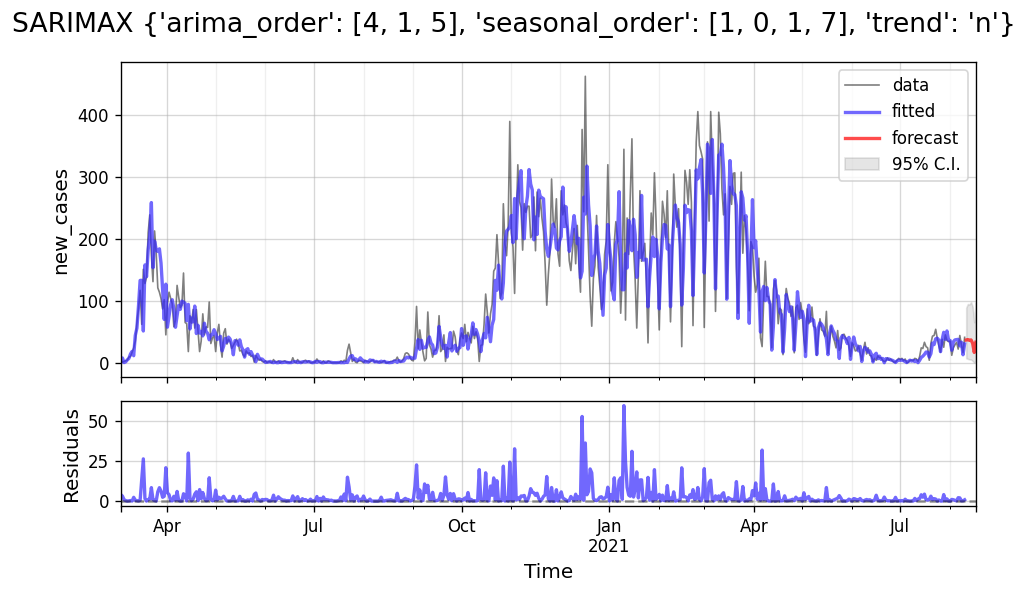

In [22]:
# Plotting results
model.plot_prediction_and_forecast(7, plot_residuals=True)

# Model 2: SARIMAX with Stringency Index as exogenous variable


In [23]:
data_idx = data[['new_cases', 'stringency_index']]

## Preliminary analysis

d:\local_project_repos\bdt_project_2021\covid19learning\venv\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


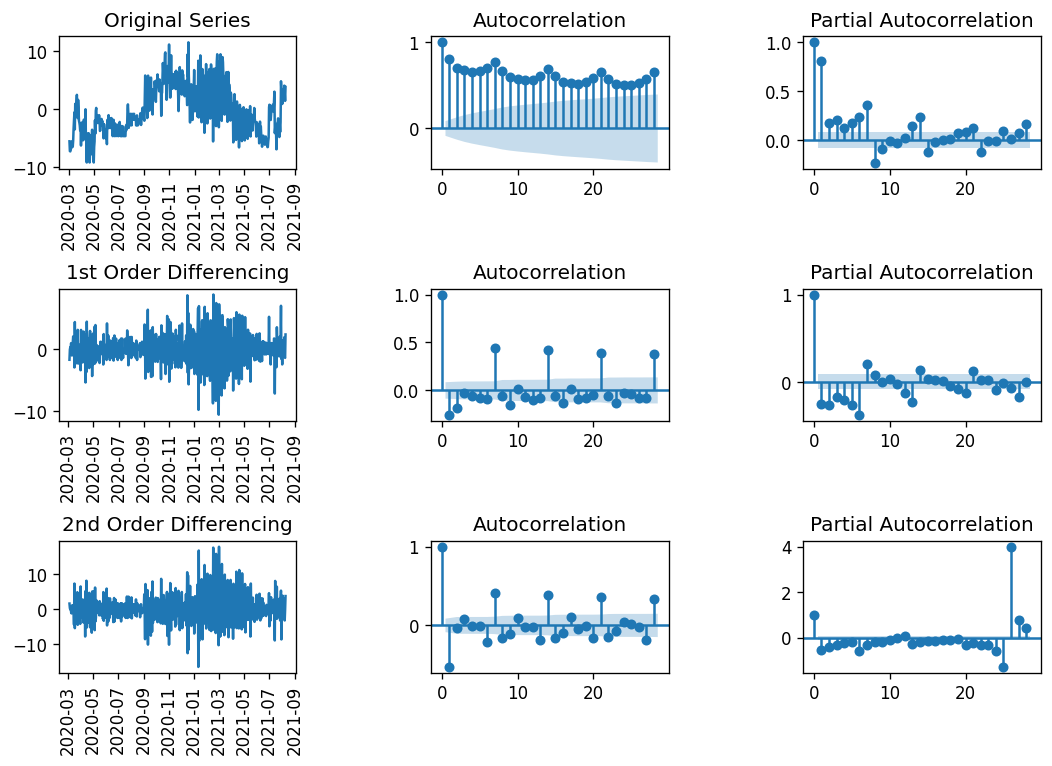

In [24]:
expr = 'new_cases ~ stringency_index'
idx_y, idx_x = dmatrices(expr, data_idx, return_type='dataframe')
olsr_idx_results = linear_model.OLS(idx_y, idx_x).fit()
olsr_idx_results.summary()

plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 3, sharex=False)
fig.tight_layout(pad=5.0)
axes[0, 0].tick_params(axis='x', rotation=90)
axes[0, 0].plot(olsr_idx_results.resid); axes[0, 0].set_title('Original Series')
plot_acf(olsr_idx_results.resid, ax=axes[0, 1])
plot_pacf(olsr_idx_results.resid, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].tick_params(axis='x', rotation=90)
axes[1, 0].plot(olsr_idx_results.resid.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(olsr_idx_results.resid.diff().dropna(), ax=axes[1, 1])
plot_pacf(olsr_idx_results.resid.diff().dropna(), ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].tick_params(axis='x', rotation=90)
axes[2, 0].plot(olsr_idx_results.resid.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(olsr_idx_results.resid.diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(olsr_idx_results.resid.diff().diff().dropna(), ax=axes[2, 2])

plt.show()

Looking at the plots, it can be noticed that the same considerations apply here as for the model with only the endogenous variable.

In this case, indeed, the hyperparameters were tuned using the following configuration:
```
{
  "outputs": ["new_cases"],
  "regressors": ["stringency_index"],
  "date_from": "2020",
  "p_values": [0,1,2,3,4,5],
  "d_values": [1],
  "q_values": [0,1,2,3,4,5],
  "P_values": [0, 1, 2],
  "D_values": [0],
  "Q_values": [0, 1, 2],
  "m_values": [7],
  "t_values": ["n"],
  "performance_measure": "rmse",
  "cv_n_splits": 30,
  "cv_max_test_size": 7,
  "parallel": true,
  "debug": false
}
```

### Analysis of best model

In [25]:
# Get the best configuration for the model using stringency index as regressor
htr_idx = htrdao.get_most_recent_record("new_cases", [regressors[0]])
# Extract best configuration from htr result
best_config_idx = htr_idx[0].results[0]["cfg"]

In [26]:
data_idx = y.join(x[["stringency_index"]])
modelidx = Sarimax(data_idx, config=best_config_idx, transformation='sqrt', convergence_warnings=False)
modelidx.fit().cross_validate(splits)
print(modelidx)

SARIMAX {'arima_order': [2, 1, 1], 'seasonal_order': [1, 0, 1, 7], 'trend': 'n'}
   transformation: sqrt
   trained (AIC=2069.462132387387)
   cross_validated {'RMSE': 35.443897659493, 'RMSE_se': 6.561777323081008}


In [27]:
modelidx.get_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         new_cases   No. Observations:                  526
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1027.731
Date:                           Thu, 12 Aug 2021   AIC                           2069.462
Time:                                   23:06:19   BIC                           2099.185
Sample:                               03-03-2020   HQIC                          2081.110
                                    - 08-10-2021                                         
Covariance Type:                             opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
stringency_index     0.0512      0.029      1.770      0.077      -0.006       0.108
ar.L1                0.0801      0.060      1.342      0.180      -0.037       0.197
ar.L2               -0.1252      0.047     -2.676      0.007      -0.217      -0.033
ma.L1               -0.6467      0.057    -11.315      0.000      -0.759      -0.535
ar.S.L7              0.9549      0.021     44.882      0.000       0.913       0.997
ma.S.L7             -0.7294      0.044    -16.462      0.000      -0.816      -0.643
sigma2               3.1083      0.138     22.536      0.000       2.838       3.379
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               112.17
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.16
Prob(H) (two-sided):                  0.26   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

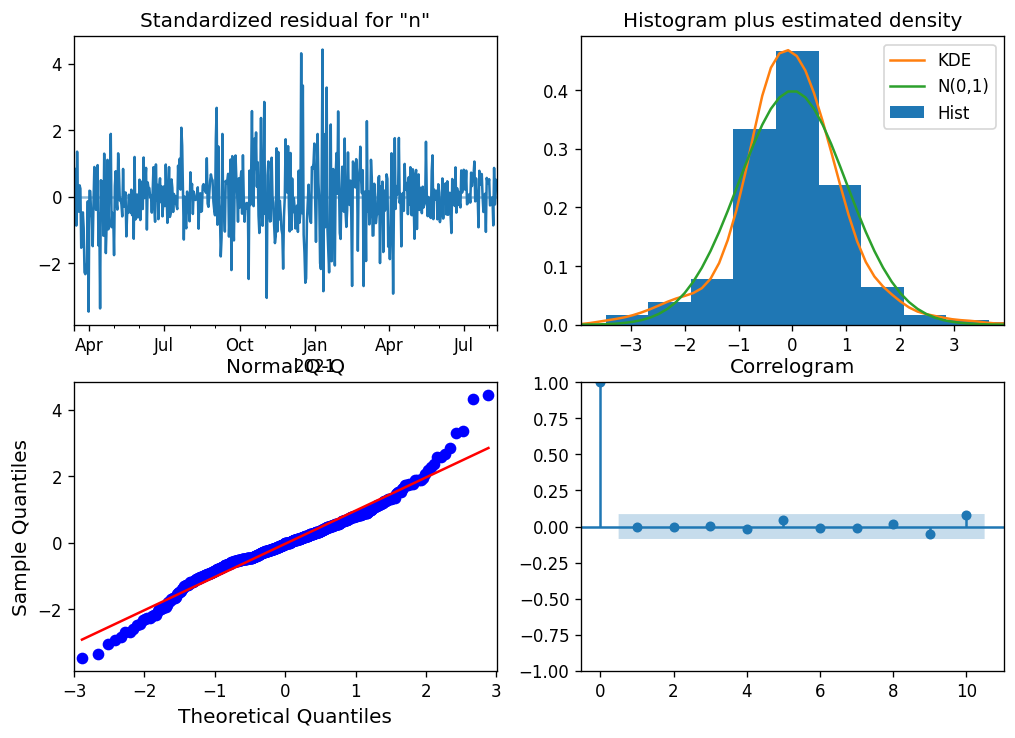

In [28]:
modelidx.plot_diagnostics()

### Predictions

In order to create forecasts, we need to provide future values for the exogenous variable. We assume it to remain constant.

In [29]:
# Create future scenario
dtidx = pd.date_range(start=data_idx.index[-1] + pd.Timedelta(days=1), end=data_idx.index[-1] + pd.Timedelta(days=7))
scenario = pd.DataFrame(index=dtidx)
exog_scenario_idx = scenario.join(data_idx['stringency_index'], how="outer").fillna(method="ffill").reindex(dtidx)

# Forecast
fit_result_df_idx = modelidx.get_prediction_and_forecast_df(7, exog=exog_scenario_idx)
fit_result_df_idx.tail(10)

,data,fitted,forecast,lower_ci,upper_ci
2021-08-08,29.0,33.665377,NaN,NaN,NaN
2021-08-09,16.0,13.580851,NaN,NaN,NaN
2021-08-10,41.0,30.425372,NaN,NaN,NaN
2021-08-11,NaN,NaN,38.934359,7.751940,93.997872
2021-08-12,NaN,NaN,39.656184,6.406721,101.273654
2021-08-13,NaN,NaN,41.574902,6.623907,106.544206
2021-08-14,NaN,NaN,43.530248,6.598469,112.927666
2021-08-15,NaN,NaN,37.808100,3.787354,107.154503
2021-08-16,NaN,NaN,21.835646,0.094929,81.678575
2021-08-17,NaN,NaN,40.495806,3.407394,118.403784


(<Figure size 960x600 with 2 Axes>,
 array([<AxesSubplot:ylabel='new_cases'>,
        <AxesSubplot:xlabel='Time', ylabel='Residuals'>], dtype=object))

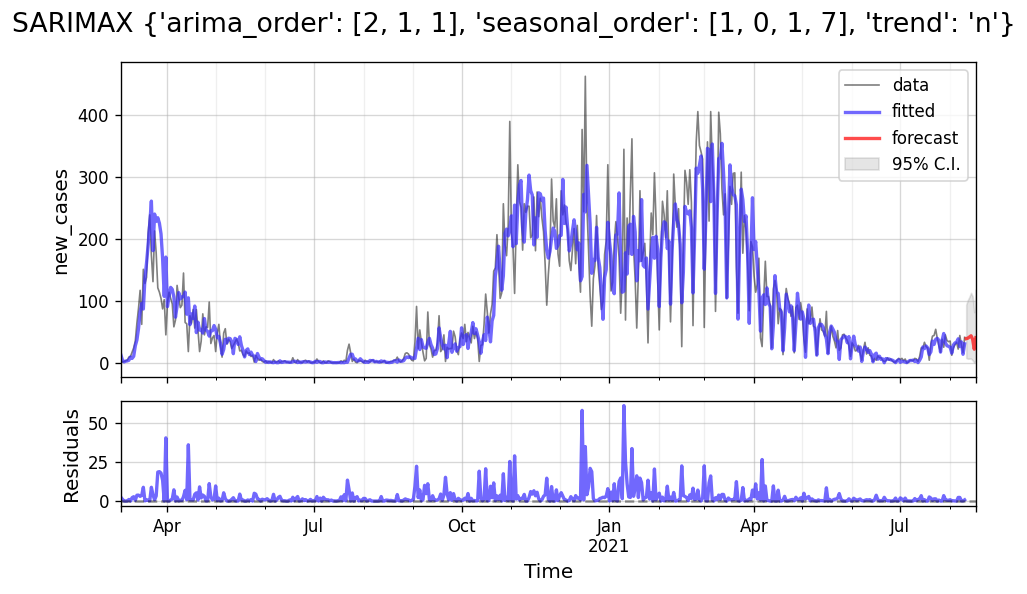

In [30]:
# Plot
modelidx.plot_prediction_and_forecast(7, exog=exog_scenario_idx, plot_residuals=True)

# Model 3: SARIMAX with vaccines-related data as exogenous variables

For this analysis we need to keep observations after the beginning of the vaccination campaign.

In [31]:
vax_data = (data[outputs].join(data[regressors[1:]])).loc['2020-12-27':]
y_vax = vax_data[outputs]

In [32]:
splitter_vax = TsCvSplitter(n_splits=30, max_test_size=7)
splits_vax = splitter_vax.split(y_vax)
(splitter_vax.min_train_size, splitter_vax.max_train_size)

(17, 220)

### Preliminary analysis 

d:\local_project_repos\bdt_project_2021\covid19learning\venv\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


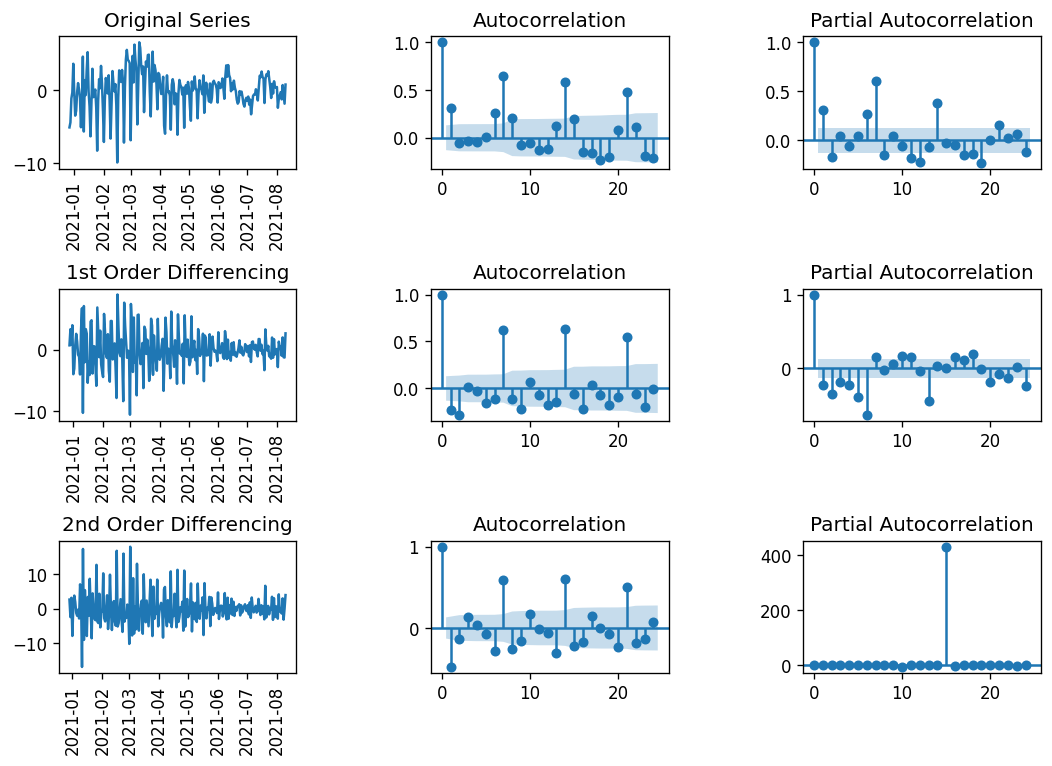

In [33]:
expr = f'new_cases ~ {"+".join(regressors[1:])}'
vax_y, vax_x = dmatrices(expr, vax_data, return_type='dataframe')
olsr_vax_results = linear_model.OLS(vax_y, vax_x).fit()
olsr_vax_results.summary()

plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 3, sharex=False)
fig.tight_layout(pad=5.0)
axes[0, 0].tick_params(axis='x', rotation=90)
axes[0, 0].plot(olsr_vax_results.resid); axes[0, 0].set_title('Original Series')
plot_acf(olsr_vax_results.resid, ax=axes[0, 1])
plot_pacf(olsr_vax_results.resid, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].tick_params(axis='x', rotation=90)
axes[1, 0].plot(olsr_vax_results.resid.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(olsr_vax_results.resid.diff().dropna(), ax=axes[1, 1])
plot_pacf(olsr_vax_results.resid.diff().dropna(), ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].tick_params(axis='x', rotation=90)
axes[2, 0].plot(olsr_vax_results.resid.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(olsr_vax_results.resid.diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(olsr_vax_results.resid.diff().diff().dropna(), ax=axes[2, 2])

plt.show()

Also in this case the hyperparameters were tuned using the following configuration, results of the same considerations done for the models above:
```
{
  "outputs": ["new_cases"],
  "regressors": ["first_doses_ag0", "first_doses_ag1",
       "first_doses_ag2", "second_doses_ag0", "second_doses_ag1",
       "second_doses_ag2", "first_doses", "second_doses"
  ],
  "date_from": "2021",
  "p_values": [0,1,2,3,4,5],
  "d_values": [1],
  "q_values": [0,1,2,3,4,5],
  "P_values": [0, 1, 2],
  "D_values": [0],
  "Q_values": [0, 1, 2],
  "m_values": [7],
  "t_values": ["n"],
  "performance_measure": "rmse",
  "cv_n_splits": 15,
  "cv_max_test_size": 7,
  "parallel": true,
  "debug": false
}
```

### Analysis of best model

In [34]:
# Get the best configuration for the model using vaccine regressors
htr_vax = htrdao.get_most_recent_record("new_cases", regressors[1:])

# Extract best configuration from htr result
best_config_vax = htr_vax[0].results[0]["cfg"]

In [35]:
vax_data = (data[outputs].join(data[regressors[1:]])).loc['2020-12-27':]
modelvax = Sarimax(vax_data, config=best_config_vax, transformation='sqrt',convergence_warnings=False)
modelvax.fit().cross_validate(splits_vax)
print(modelvax)

SARIMAX {'arima_order': [5, 1, 0], 'seasonal_order': [1, 0, 1, 7], 'trend': 'n'}
   transformation: sqrt
   trained (AIC=173.7072127931282)
   cross_validated {'RMSE': 51.031490897907524, 'RMSE_se': 47.776245782677876}


In [36]:
modelvax.get_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  227
Model:             SARIMAX(5, 1, 0)x(1, 0, [1], 7)   Log Likelihood                 -70.854
Date:                             Thu, 12 Aug 2021   AIC                            173.707
Time:                                     23:06:44   BIC                            227.563
Sample:                                 12-27-2020   HQIC                           195.470
                                      - 08-10-2021                                         
Covariance Type:                               opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
first_doses_ag0  -2.403e-06   5.81e-05     -0.041      0.967      -0.000       0.000
first_doses_ag1   1.008e-05   4.73e-05      0.213      0.831   -8.25e-05       0.000
first_doses_ag2   2.048e-05   3.09e-05      0.663      0.507   -4.01e-05     8.1e-05
second_doses_ag0  1.082e-05      0.000      0.088      0.930      -0.000       0.000
second_doses_ag1  3.392e-05   7.83e-05      0.433      0.665      -0.000       0.000
second_doses_ag2 -1.586e-06    4.4e-05     -0.036      0.971   -8.79e-05    8.47e-05
first_doses      -2.435e-05   1.93e-05     -1.264      0.206   -6.21e-05    1.34e-05
second_doses     -1.972e-05   3.46e-05     -0.570      0.569   -8.75e-05    4.81e-05
ar.L1               -0.5188      0.127     -4.080      0.000      -0.768      -0.270
ar.L2               -0.5403      0.152     -3.545      0.000      -0.839      -0.242
ar.L3               -0.3873      0.157     -2.472      0.013      -0.694      -0.080
ar.L4               -0.2932      0.141     -2.076      0.038      -0.570      -0.016
ar.L5               -0.3075      0.127     -2.422      0.015      -0.556      -0.059
ar.S.L7              0.8377      0.111      7.567      0.000       0.621       1.055
ma.S.L7             -0.4597      0.235     -1.957      0.050      -0.920       0.001
sigma2               0.1860      0.029      6.372      0.000       0.129       0.243
===================================================================================
Ljung-Box (L1) (Q):                   3.50   Jarque-Bera (JB):                46.05
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.53
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.34e+17. Standard errors may be unstable.
"""

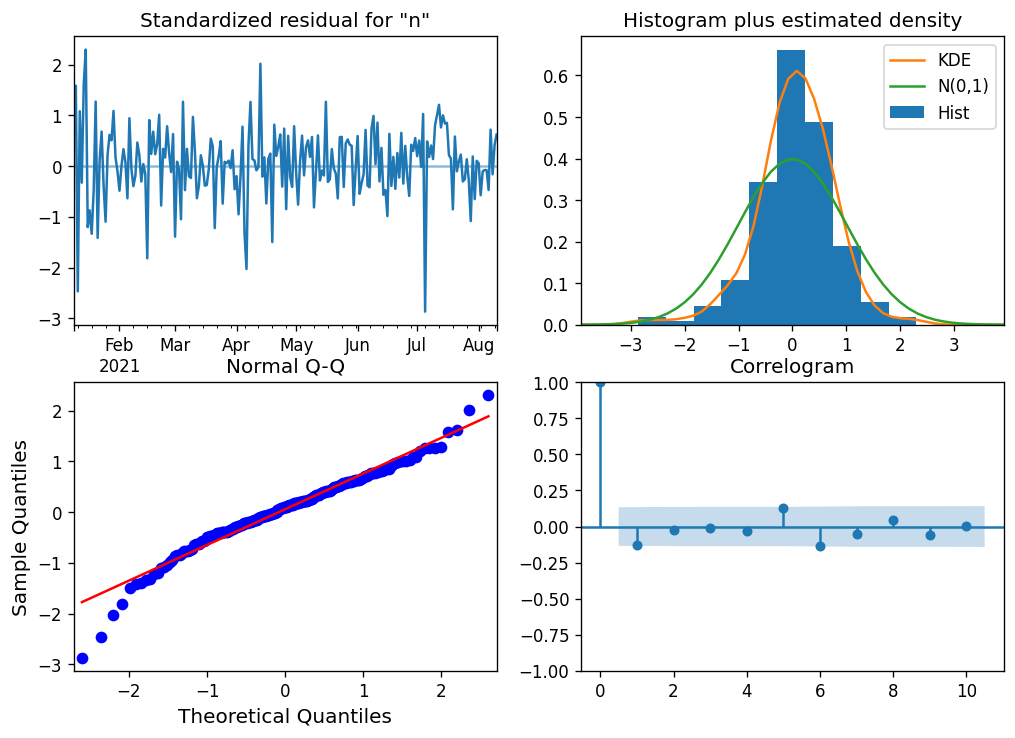

In [37]:
modelvax.plot_diagnostics()

In [38]:
# Create scenario
dtidx = pd.date_range(start=y_vax.index[-1] + pd.Timedelta(days=1), end=y_vax.index[-1] + pd.Timedelta(days=7))
scenario = pd.DataFrame(index=dtidx)
exog_scenario_vax = scenario.join(vax_data[regressors[1:]], how="outer").fillna(method="ffill").reindex(dtidx)

# Forecast
fit_result_df_vax = modelvax.get_prediction_and_forecast_df(7, exog=exog_scenario_vax)
fit_result_df_vax.tail(10)

,data,fitted,forecast,lower_ci,upper_ci
2021-08-08,5.385165,5.710639,NaN,NaN,NaN
2021-08-09,4.000000,3.316603,NaN,NaN,NaN
2021-08-10,6.403124,5.115497,NaN,NaN,NaN
2021-08-11,NaN,NaN,5.934035,2.529973,10.767496
2021-08-12,NaN,NaN,5.751446,2.131734,11.131489
2021-08-13,NaN,NaN,6.013204,2.242053,11.607774
2021-08-14,NaN,NaN,6.658703,2.571637,12.654098
2021-08-15,NaN,NaN,5.976246,2.072049,11.901195
2021-08-16,NaN,NaN,5.008485,1.487564,10.603305
2021-08-17,NaN,NaN,6.833010,2.336564,13.685730


(<Figure size 960x600 with 2 Axes>,
 array([<AxesSubplot:ylabel='new_cases'>,
        <AxesSubplot:xlabel='Time', ylabel='Residuals'>], dtype=object))

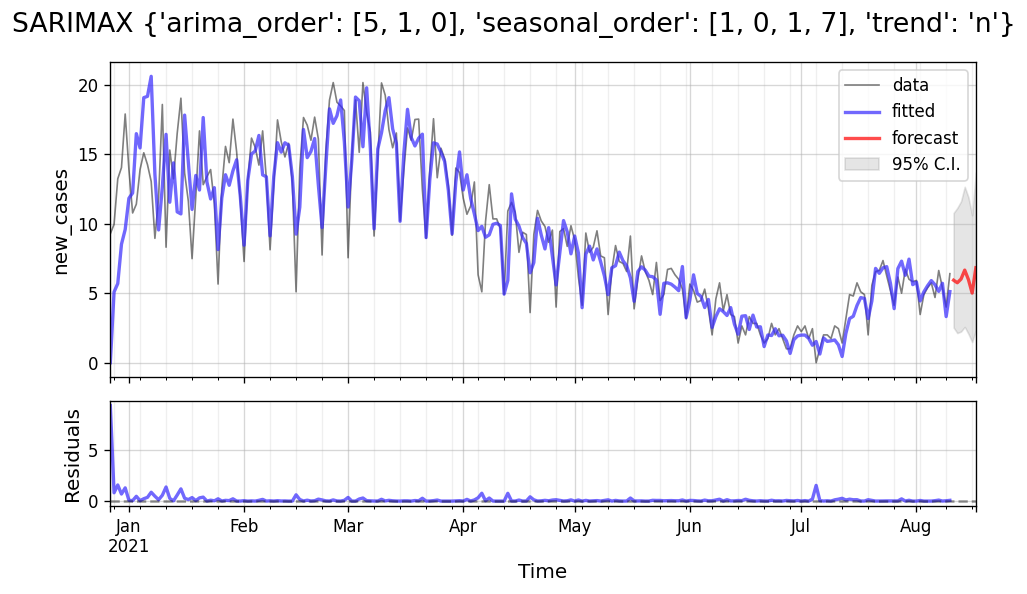

In [39]:
# Plot
modelvax.plot_prediction_and_forecast(7, exog=exog_scenario_vax, plot_residuals=True)

# Models comparison

Let's compare the three models.

(<Figure size 960x360 with 1 Axes>,
 [<AxesSubplot:xlabel='Time', ylabel='new_cases'>])

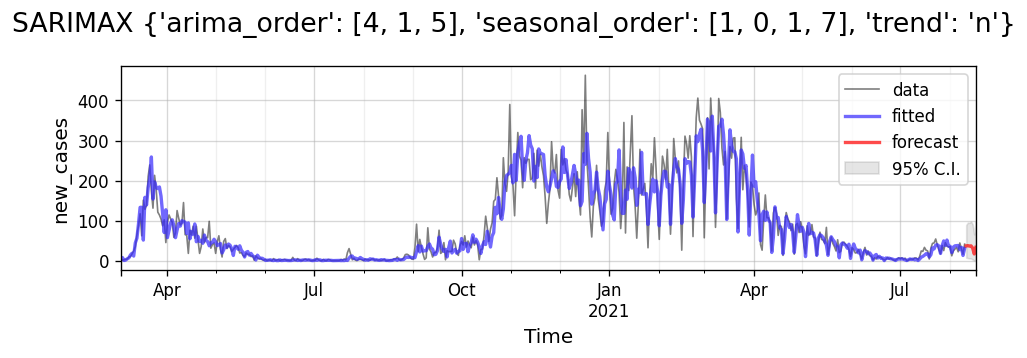

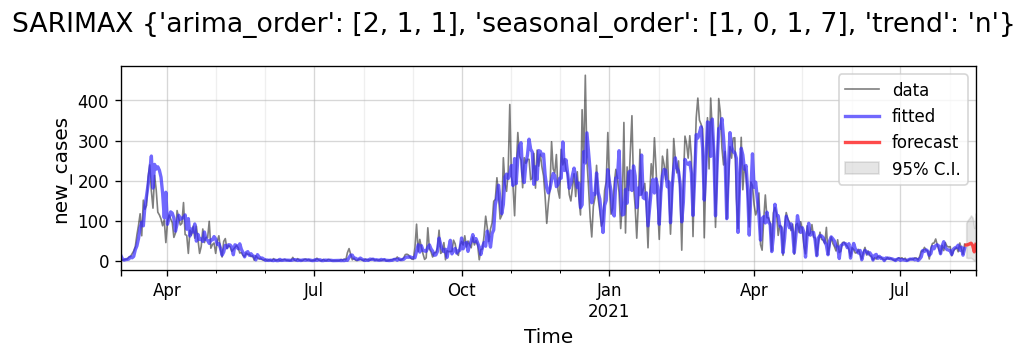

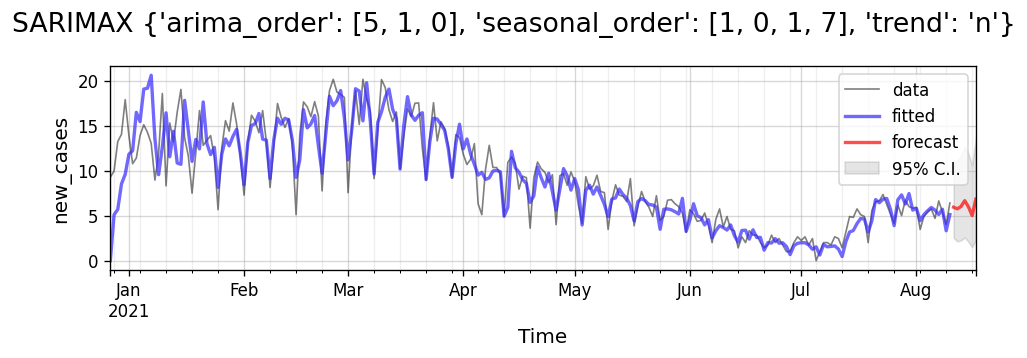

In [40]:
model.plot_prediction_and_forecast(7)
modelidx.plot_prediction_and_forecast(7, exog=exog_scenario_idx)
modelvax.plot_prediction_and_forecast(7, exog=exog_scenario_vax)

In [41]:
print("Model with endog only:", model.test_performance)
print("Model with stringency idx:", modelidx.test_performance)
print("Model with vaccines regressors:", modelvax.test_performance)

Model with endog only: {'RMSE': 34.69652132312452, 'RMSE_se': 6.6010928171439005}
Model with stringency idx: {'RMSE': 35.443897659493, 'RMSE_se': 6.561777323081008}
Model with vaccines regressors: {'RMSE': 51.031490897907524, 'RMSE_se': 47.776245782677876}


Comparison of the three values for RMSE allows us to assess which is the best model.

Whilst the first two, containing no regressors and only one regressor respectively, have similar RMSE, the third one has a much worse performance measure.

Overall, the model that appears to have lower RMSE is the one without regressors. This corresponds to the basic time series analysis of new cases without using any external regressor. Stringency index, despite not worsening the model too excessively, still worsens the performance of the base model. The model containing vaccine variables, on the other hand, performs much worse than the others. 

This analysis allows us to state that this model, with the quantities that we decided to use as regressors, is not effective in predicting new infections better than a simple SARIMA model. This must be attributed to the fact that the trend of the new cases is not particularly influenced by the quantities we have analysed.

We therefore present the forecasts computed by the SARIMA(4, 1, 5)x(1, 0, 1, 7) model as our best attempt to forecasting new COVID-19 cases in Trentino.

In [42]:
forecast_df = model.forecast(7)
forecast_df

,forecast,se,lower_ci,upper_ci
2021-08-11,36.771900,2.960432,7.245185,89.043372
2021-08-12,37.417487,3.421118,6.208979,94.910164
2021-08-13,36.193368,3.550828,5.395431,94.272021
2021-08-14,36.842201,3.800695,5.056899,97.827932
2021-08-15,31.323557,4.008707,2.797435,90.648242
2021-08-16,16.593531,4.197547,0.003359,65.433109
2021-08-17,33.091604,4.424060,2.657062,97.515839


Based on the results obtained on 10 August 2021, there would be an average of 6 new cases per day over the next 7 days.